In [62]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This tutorial uses a dataset of animal photos. The dataset contains five sub-directories, one per class:

location = D:\datasets\iNaturalCleaned

```
D:\datasets\iNaturalCleaned\blackBear
D:\datasets\iNaturalCleaned\coyote
D:\datasets\iNaturalCleaned\ruffedGrouse
D:\datasets\iNaturalCleaned\turkey
D:\datasets\iNaturalCleaned\whitetailDeer
```

Total number of images: 25000


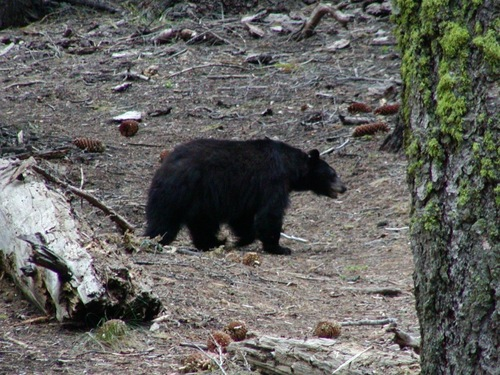

In [9]:
# Specify the location of your dataset
data_dir = pathlib.Path(r'D:\datasets\iNaturalCleaned_temp')

# Count the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Total number of images: {image_count}")

# Example: Load and display an image from the 'blackBear' folder
black_bears = list(data_dir.glob('blackBear/*'))
PIL.Image.open(str(black_bears[0]))

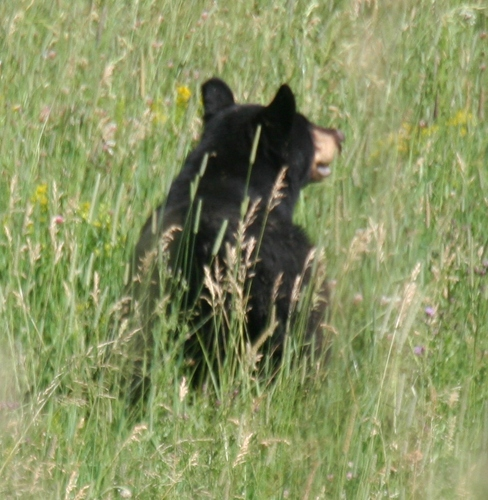

In [9]:
PIL.Image.open(str(black_bears[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [63]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25000 files belonging to 5 classes.
Using 20000 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25000 files belonging to 5 classes.
Using 5000 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [13]:
class_names = train_ds.class_names
print(class_names)

['blackBear', 'coyote', 'ruffedGrouse', 'turkey', 'whitetailDeer']


## Visualize the data


Here are the first nine images from the training dataset:

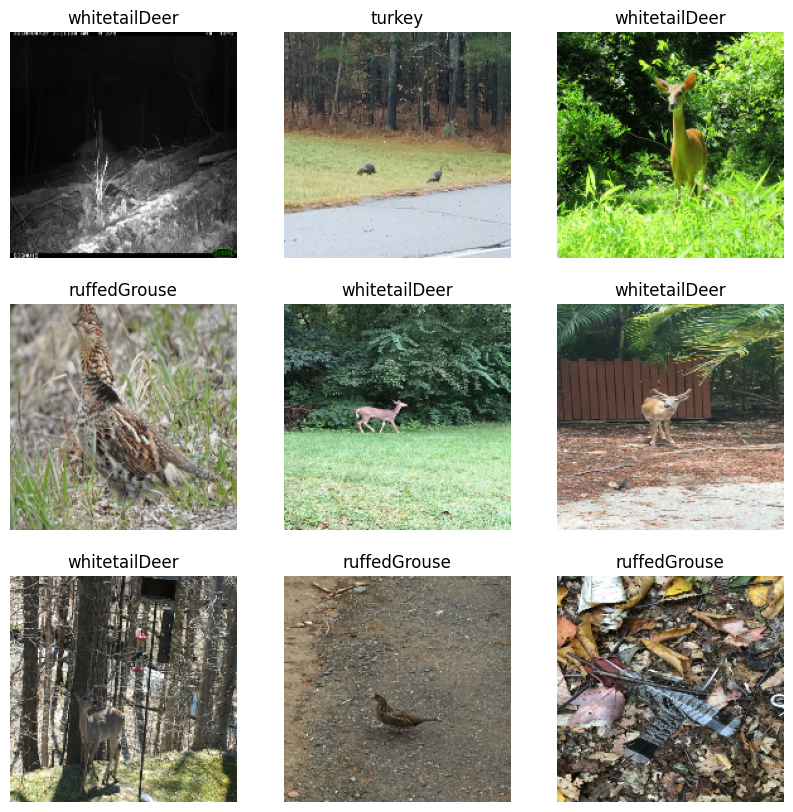

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [15]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.008859768 1.0


## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\kdlor\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 194ms/step - accuracy: 0.3134 - loss: 1.5398 - val_accuracy: 0.4462 - val_loss: 1.3435
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - accuracy: 0.4771 - loss: 1.2815 - val_accuracy: 0.5048 - val_loss: 1.2524
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 121ms/step - accuracy: 0.5545 - loss: 1.1286 - val_accuracy: 0.4992 - val_loss: 1.2619
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.6602 - loss: 0.8962 - val_accuracy: 0.4866 - val_loss: 1.3946
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.7625 - loss: 0.6279 - val_accuracy: 0.4948 - val_loss: 1.6760
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.8685 - loss: 0.3799 - val_accuracy: 0.4836 - val_loss: 2.1524
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.9256 - loss: 0.2260 - val_accuracy: 0.4672 - val_loss: 2.5256
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 124ms/step - accuracy: 0.9563 - loss: 

```
Epoch 1/10
194ms/step - accuracy: 0.3134 - loss: 1.5398 - val_accuracy: 0.4462 - val_loss: 1.3435

Epoch 2/10
133ms/step - accuracy: 0.4771 - loss: 1.2815 - val_accuracy: 0.5048 - val_loss: 1.2524

Epoch 3/10
121ms/step - accuracy: 0.5545 - loss: 1.1286 - val_accuracy: 0.4992 - val_loss: 1.2619

Epoch 4/10
118ms/step - accuracy: 0.6602 - loss: 0.8962 - val_accuracy: 0.4866 - val_loss: 1.3946

Epoch 5/10
118ms/step - accuracy: 0.7625 - loss: 0.6279 - val_accuracy: 0.4948 - val_loss: 1.6760

Epoch 6/10
119ms/step - accuracy: 0.8685 - loss: 0.3799 - val_accuracy: 0.4836 - val_loss: 2.1524

Epoch 7/10
118ms/step - accuracy: 0.9256 - loss: 0.2260 - val_accuracy: 0.4672 - val_loss: 2.5256

Epoch 8/10
124ms/step - accuracy: 0.9563 - loss: 0.1435 - val_accuracy: 0.4734 - val_loss: 3.1564

Epoch 9/10
120ms/step - accuracy: 0.9715 - loss: 0.0976 - val_accuracy: 0.4534 - val_loss: 3.8991

Epoch 10/10
122ms/step - accuracy: 0.9772 - loss: 0.0823 - val_accuracy: 0.4786 - val_loss: 4.1128
```

The increase in accuracy but decrease in validation accuracy is said to be a sign of overfitting or can also be a sign that the dataset is to complex for the size of the dataset that uou are using to train it.

Solutions

- Increase dataset size (artifically using data augmenation if can not get mroe data)
- Stop early when validation accuracy starts to dip

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

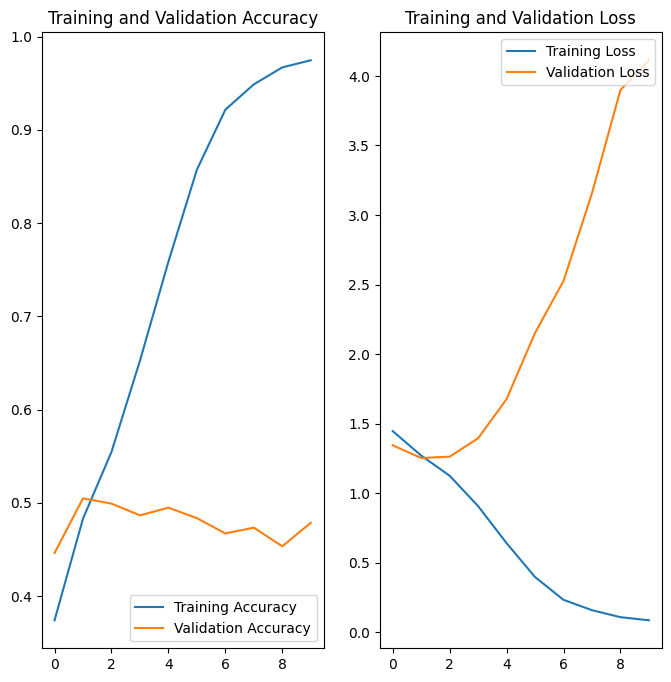

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\kdlor\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Visualize a few augmented examples by applying data augmentation to the same image several times:

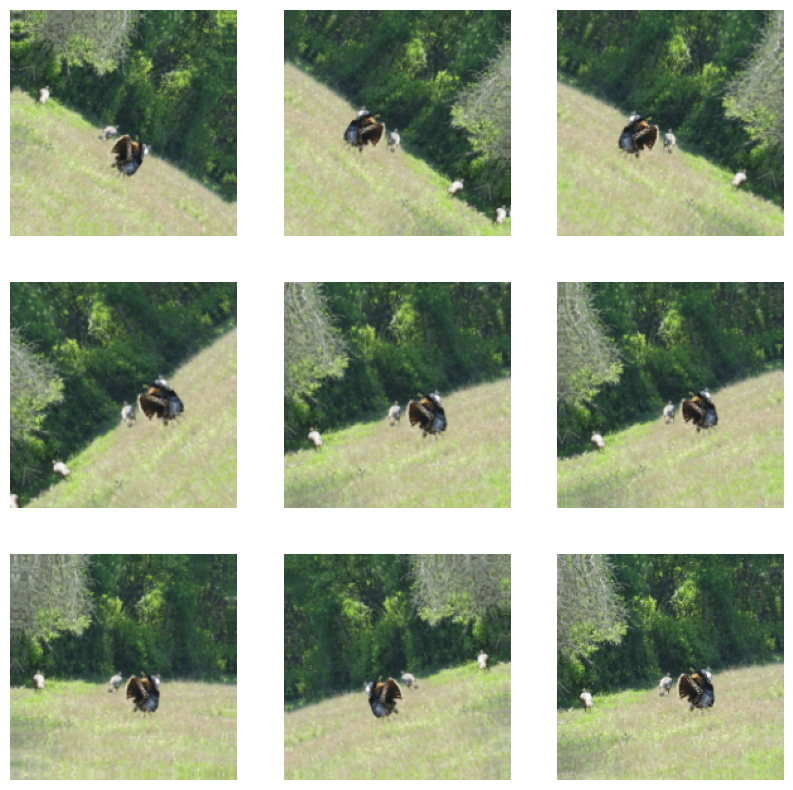

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [21]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 136s 215ms/step - accuracy: 0.2825 - loss: 1.5680 - val_accuracy: 0.3832 - val_loss: 1.5136
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.4165 - loss: 1.3973 - val_accuracy: 0.4236 - val_loss: 1.4027
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 151ms/step - accuracy: 0.4478 - loss: 1.3377 - val_accuracy: 0.4598 - val_loss: 1.3404
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - accuracy: 0.4737 - loss: 1.2900 - val_accuracy: 0.4586 - val_loss: 1.3355
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - accuracy: 0.4913 - loss: 1.2618 - val_accuracy: 0.4654 - val_loss: 1.3254
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - accuracy: 0.4963 - loss: 1.2385 - val_accuracy: 0.4770 - val_loss: 1.2963
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - accuracy: 0.5116 - loss: 1.2181 - val_accuracy: 0.4754 - val_loss: 1.3453
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 151ms/step - accuracy: 0.5206 - loss: 

```
Epoch 1/15
215ms/step - accuracy: 0.2825 - loss: 1.5680 - val_accuracy: 0.3832 - val_loss: 1.5136

Epoch 2/15
152ms/step - accuracy: 0.4165 - loss: 1.3973 - val_accuracy: 0.4236 - val_loss: 1.4027

Epoch 3/15
151ms/step - accuracy: 0.4478 - loss: 1.3377 - val_accuracy: 0.4598 - val_loss: 1.3404

Epoch 4/15
151ms/step - accuracy: 0.4737 - loss: 1.2900 - val_accuracy: 0.4586 - val_loss: 1.3355

Epoch 5/15
151ms/step - accuracy: 0.4913 - loss: 1.2618 - val_accuracy: 0.4654 - val_loss: 1.3254

Epoch 6/15
151ms/step - accuracy: 0.4963 - loss: 1.2385 - val_accuracy: 0.4770 - val_loss: 1.2963

Epoch 7/15
151ms/step - accuracy: 0.5116 - loss: 1.2181 - val_accuracy: 0.4754 - val_loss: 1.3453

Epoch 8/15
151ms/step - accuracy: 0.5206 - loss: 1.2000 - val_accuracy: 0.5098 - val_loss: 1.2188

Epoch 9/15
151ms/step - accuracy: 0.5265 - loss: 1.1655 - val_accuracy: 0.5108 - val_loss: 1.2243

Epoch 10/15
151ms/step - accuracy: 0.5457 - loss: 1.1380 - val_accuracy: 0.5196 - val_loss: 1.1765

Epoch 11/15
151ms/step - accuracy: 0.5482 - loss: 1.1397 - val_accuracy: 0.5320 - val_loss: 1.1699

Epoch 12/15
151ms/step - accuracy: 0.5574 - loss: 1.1225 - val_accuracy: 0.5270 - val_loss: 1.2081

Epoch 13/15
152ms/step - accuracy: 0.5548 - loss: 1.1136 - val_accuracy: 0.5234 - val_loss: 1.2154

Epoch 14/15
151ms/step - accuracy: 0.5651 - loss: 1.1079 - val_accuracy: 0.5278 - val_loss: 1.1973

Epoch 15/15
152ms/step - accuracy: 0.5640 - loss: 1.0999 - val_accuracy: 0.5364 - val_loss: 1.1767
```

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

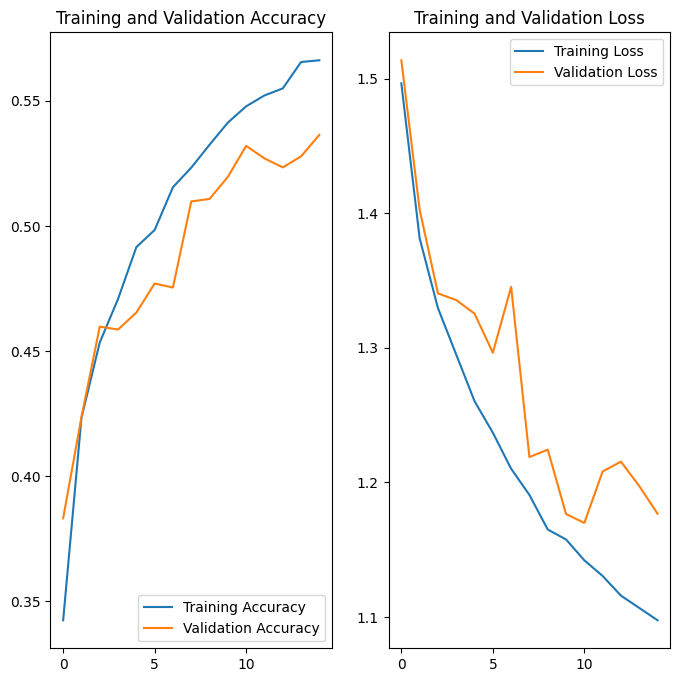

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

Test out different animal images here

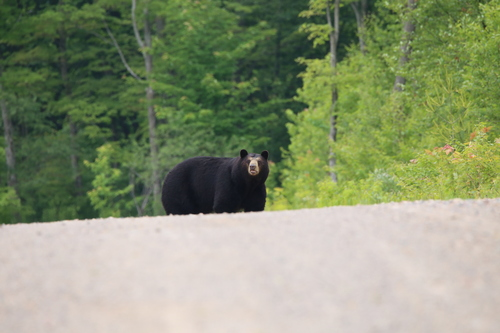

In [100]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('blackBear/*'))
test_image_path = (test_image[5654])
PIL.Image.open(str(test_image[5654]))

In [31]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
This image most likely belongs to blackBear with a 98.89 percent confidence.


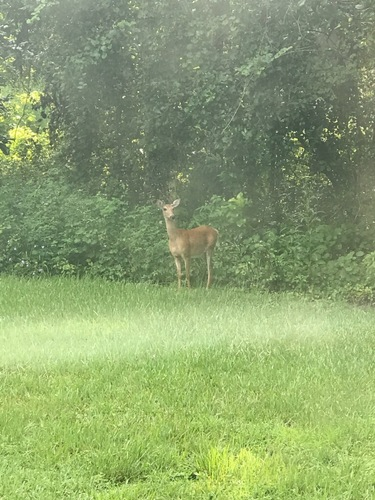

In [37]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('whitetailDeer/*'))
test_image_path = (test_image[5601])
PIL.Image.open(str(test_image[5601]))

In [38]:

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
This image most likely belongs to whitetailDeer with a 76.69 percent confidence.


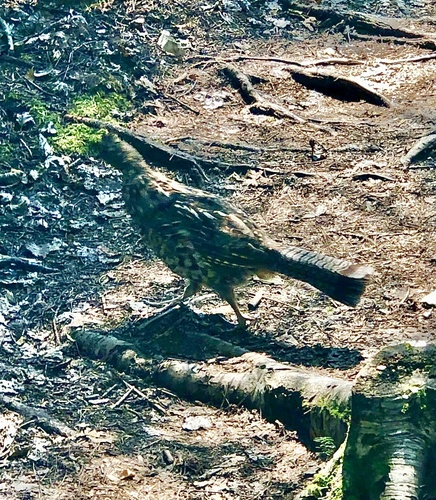

In [39]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('ruffedGrouse/*'))
test_image_path = (test_image[5656])
PIL.Image.open(str(test_image[5656]))

In [40]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image most likely belongs to ruffedGrouse with a 59.36 percent confidence.


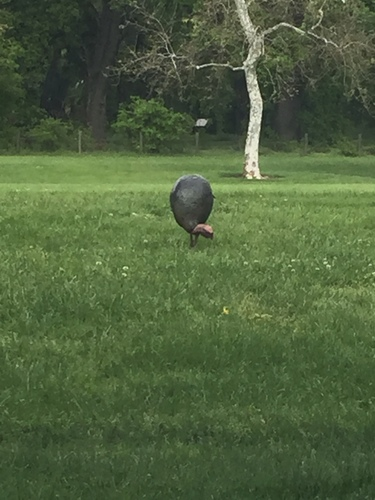

In [41]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('turkey/*'))
test_image_path = (test_image[5655])
PIL.Image.open(str(test_image[5655]))

In [42]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
This image most likely belongs to turkey with a 63.98 percent confidence.


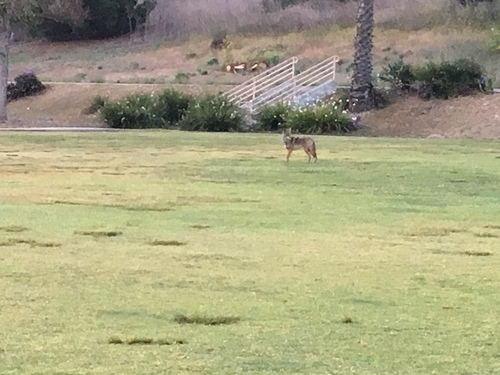

In [50]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('coyote/*'))
test_image_path = (test_image[5604])
PIL.Image.open(str(test_image[5604]))

In [51]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to coyote with a 43.38 percent confidence.


## Save base model

In [53]:
# Save the model
model.save(r'C:\Users\kdlor\Documents\Documents\projects\ImageClassification\trailSortTF1.keras')



## Running Model

### Load the Model

In [80]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model(r'C:\Users\kdlor\Documents\Documents\projects\ImageClassification\trailSortTF1.keras')


### Prepare Input Data

You need to preprocess the input data (images) similarly to how you did when training the model. This typically includes resizing the image and normalizing pixel values.

In [81]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path, target_size):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    return img_array


### Predictions

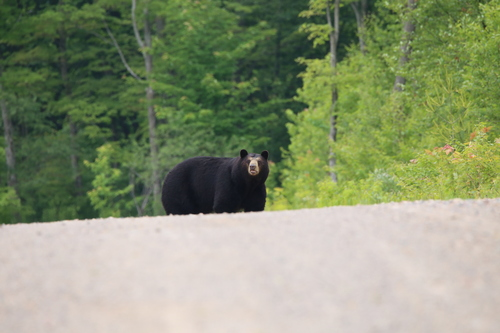

In [103]:
import os

# Define the target size as per your model's input shape
target_size = (img_height, img_width)  # Set this according to your model

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('blackBear/*'))
test_image_path = (test_image[5654])
PIL.Image.open(str(test_image[5654]))



In [104]:
# class_names = 0,1,2,3,4, - blackBear,coyote,ruffedGrouse,turkey,whitetailDeer

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
This image most likely belongs to blackBear with a 98.89 percent confidence.


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [ ]:
import tensorflow as tf
print(tf.__version__)

model = tf.keras.models.load_model(r'C:\Users\kdlor\Documents\Documents\projects\ImageClassification\trailSortTF1.keras')

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(r'C:\Users\kdlor\Documents\Documents\projects\ImageClassification\trailSortTFLite1.tflite', 'wb') as f:
    f.write(tflite_model)

